# Multipose Detection in Humans using MoveNet.Lightning 

### Dependencies

In [1]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tensorflow-hub opencv-python matplotlib

     -------------------------------------- 438.0/438.0 MB 2.9 MB/s eta 0:00:00
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)
     ---------------------------------------- 7.2/7.2 MB 21.9 MB/s eta 0:00:00
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached libclang-14.0.1-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
     ------------------------------------- 904.1/904.1 kB 14.2 MB/s eta 0:00:00
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     ---------------------------------------- 1.5/1.5 MB 18.5 MB/s eta 0:00:00
     --------------------------------------- 14.7/14.7 MB 21.8 MB/s eta 0:00:00
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
     ---------------

### Imports and Initialization

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
model= hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')

In [3]:
movenet= model.signatures['serving_default']

### Master VideoCapture call

In [117]:
cap= cv2.VideoCapture('football.mp4')
while cap.isOpened():
  ret, frame= cap.read()

  img= frame.copy()
  img= tf.image.resize_with_pad(tf.expand_dims(img, axis= 0), 544, 1024)
  input_img= tf.cast(img, dtype= tf.int32)
  
  results= movenet(input_img)
  keypoints_and_scores= results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))  
  
  loop_through_people(frame, keypoints_and_scores, EDGES, 0.3)

  cv2.imshow('Movenet Multipose Window', frame)

  if cv2.waitKey(10) & 0xFF==ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

### Scaling and Metrics

In [91]:
1080/2048

0.52734375

In [102]:
1024/32

32.0

In [103]:
32*17

544

In [118]:
frame

array([[[217, 211, 219],
        [217, 211, 219],
        [217, 210, 221],
        ...,
        [199, 190, 194],
        [199, 190, 194],
        [199, 190, 194]],

       [[210, 204, 212],
        [210, 204, 212],
        [210, 203, 214],
        ...,
        [199, 190, 194],
        [199, 190, 194],
        [199, 190, 194]],

       [[209, 203, 211],
        [209, 203, 211],
        [209, 202, 213],
        ...,
        [196, 187, 191],
        [196, 187, 191],
        [196, 187, 191]],

       ...,

       [[ 47,  70,  69],
        [ 47,  70,  69],
        [ 47,  70,  69],
        ...,
        [ 41,  67,  70],
        [ 41,  67,  70],
        [ 41,  67,  70]],

       [[ 50,  73,  72],
        [ 50,  73,  72],
        [ 48,  71,  70],
        ...,
        [ 41,  67,  70],
        [ 41,  67,  70],
        [ 41,  67,  70]],

       [[ 51,  74,  73],
        [ 51,  74,  73],
        [ 50,  73,  72],
        ...,
        [ 40,  66,  69],
        [ 40,  66,  69],
        [ 40,  66,  69]]

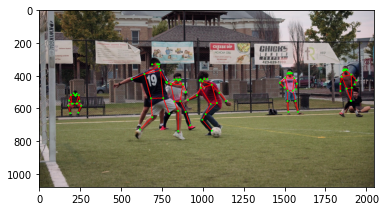

In [119]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Keypoint Matrix x Confidence Scores

In [120]:
keypoints_and_scores[0]

array([[0.48517755, 0.10898407, 0.35875612],
       [0.47976708, 0.11077929, 0.46474373],
       [0.47994435, 0.1071113 , 0.4717213 ],
       [0.4723238 , 0.11269185, 0.4148368 ],
       [0.47123876, 0.10366924, 0.4909297 ],
       [0.4823754 , 0.11886524, 0.79927677],
       [0.48038223, 0.0954906 , 0.78360116],
       [0.51465076, 0.12093391, 0.5353545 ],
       [0.51162773, 0.09023584, 0.739223  ],
       [0.5279961 , 0.11441359, 0.5836447 ],
       [0.5291515 , 0.10141041, 0.48077533],
       [0.52872527, 0.11163795, 0.7669046 ],
       [0.5289806 , 0.09788188, 0.689511  ],
       [0.5415193 , 0.12559794, 0.8202237 ],
       [0.53999746, 0.08833516, 0.6755993 ],
       [0.5804207 , 0.11740522, 0.6815445 ],
       [0.58320117, 0.09349357, 0.8147298 ]], dtype=float32)

In [125]:
scores= keypoints_and_scores[0][:, 2]
scores

array([0.35875612, 0.46474373, 0.4717213 , 0.4148368 , 0.4909297 ,
       0.79927677, 0.78360116, 0.5353545 , 0.739223  , 0.5836447 ,
       0.48077533, 0.7669046 , 0.689511  , 0.8202237 , 0.6755993 ,
       0.6815445 , 0.8147298 ], dtype=float32)

### Logistics for Multi-Body Detection

In [70]:
def loop_through_people(frame, keypoints_and_scores, edges, confidence_threshold):
    for person in keypoints_and_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

### Render Keypoints, Edges and Connections

In [71]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)

In [72]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [73]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)